In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv ("household_power_consumption.txt", sep=";",
                    header=0, low_memory=False, infer_datetime_format=True, 
                    parse_dates={"datetime":[0,1]},index_col=["datetime"])

In [3]:
df.replace("?", np.nan, inplace = True)
df = df.astype('float32')
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [5]:
#daily rDownsample 
df_daily = df.resample('D').sum()
df_daily.head(3)
df_daily.isna().sum()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

C:\Users\miky\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


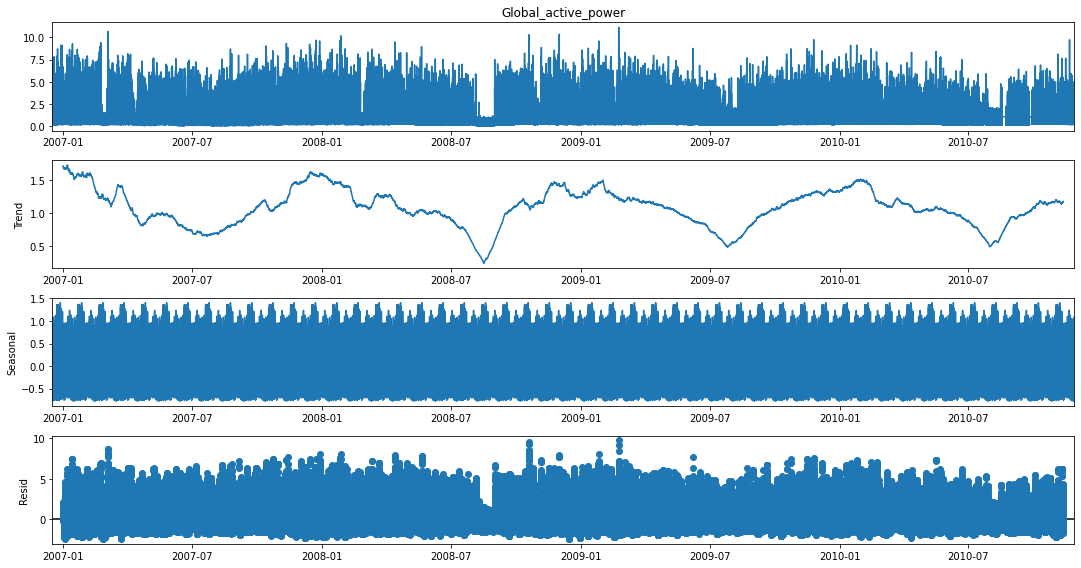

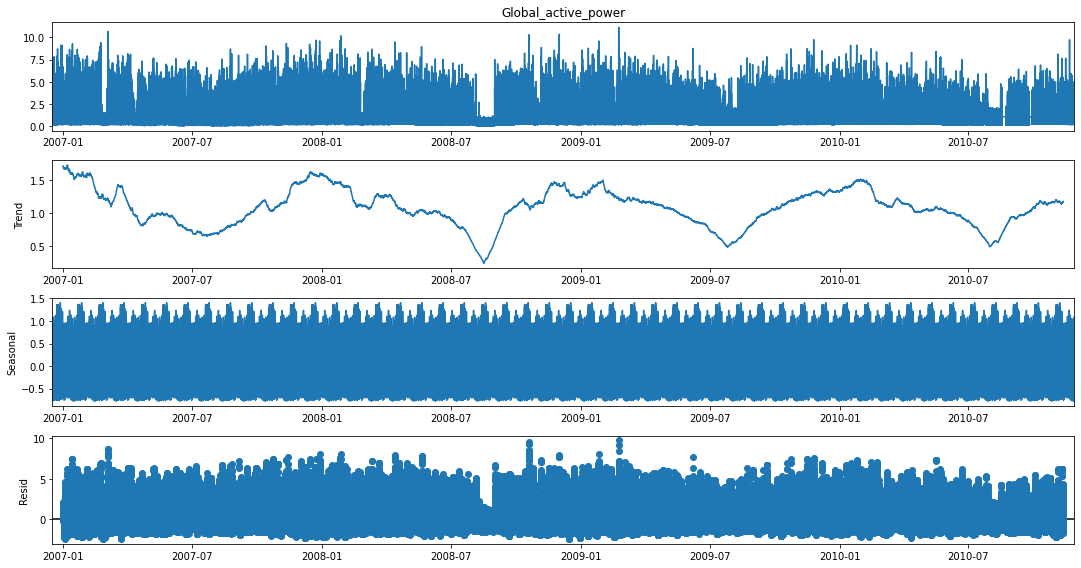

In [6]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 15, 8

decompose_series = sm.tsa.seasonal_decompose(df['Global_active_power'], freq = 60 * 24* 30, model='additive')
decompose_series.plot()
plt.show()

In [7]:
dff = df_daily.reset_index()
from scipy.stats import pearsonr

corr, p = pearsonr(dff['Global_active_power'], dff['Global_reactive_power'])

In [8]:
corr, p = pearsonr(dff['Voltage'], dff['Global_intensity'])

In [9]:
data = dff[['datetime', 'Global_active_power']]
data = data.rename(columns={'datetime': 'ds',
                        'Global_active_power': 'y'})

data.head(3)

,ds,y
0,2006-12-16,1209.176025
1,2006-12-17,3390.459961
2,2006-12-18,2203.825928


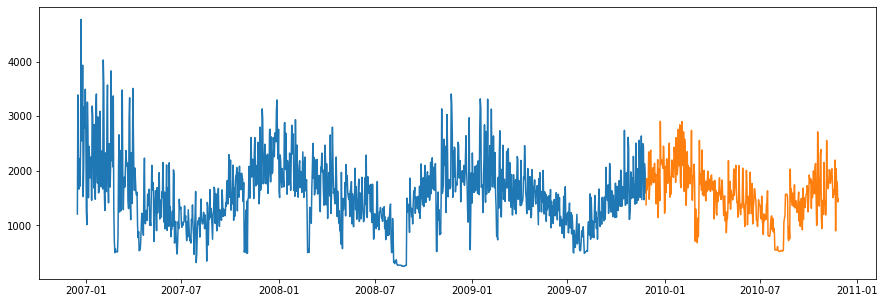

In [10]:
n_tests = 365
df_train = data[:-n_tests]
df_test = data[-n_tests:]

# visualize
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train['ds'], df_train['y'])
ax.plot(df_test['ds'], df_test['y'])

In [11]:
from fbprophet import Prophet

model = Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\Users\miky\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
forecast = model.predict(df_test)
forecast.head(3)
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1233.101392,1546.610313,2640.009022,1233.101392,1233.101392,868.164181,868.164181,868.164181,350.126165,...,-64.129799,-64.129799,-64.129799,582.167815,582.167815,582.167815,0.0,0.0,0.0,2101.265572
1,2009-11-28,1233.229560,1841.341882,2915.574905,1233.229560,1233.229560,1171.435259,1171.435259,1171.435259,350.126165,...,245.839558,245.839558,245.839558,575.469536,575.469536,575.469536,0.0,0.0,0.0,2404.664820
2,2009-11-29,1233.357729,1811.661758,2933.589702,1233.357729,1233.357729,1145.463079,1145.463079,1145.463079,350.126165,...,228.537863,228.537863,228.537863,566.799051,566.799051,566.799051,0.0,0.0,0.0,2378.820807


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
362,2010-11-24,1279.498388,1607.173535,2742.934486,1267.616884,1292.028279,910.364209,910.364209,910.364209,350.126165,...,-24.719953,-24.719953,-24.719953,584.957997,584.957997,584.957997,0.0,0.0,0.0,2189.862597
363,2010-11-25,1279.626556,1457.519738,2569.200130,1267.667718,1292.231662,742.886375,742.886375,742.886375,350.126165,...,-194.901468,-194.901468,-194.901468,587.661679,587.661679,587.661679,0.0,0.0,0.0,2022.512932
364,2010-11-26,1279.754725,1581.698745,2723.514955,1267.719499,1292.396033,873.048934,873.048934,873.048934,350.126165,...,-64.129799,-64.129799,-64.129799,587.052568,587.052568,587.052568,0.0,0.0,0.0,2152.803659


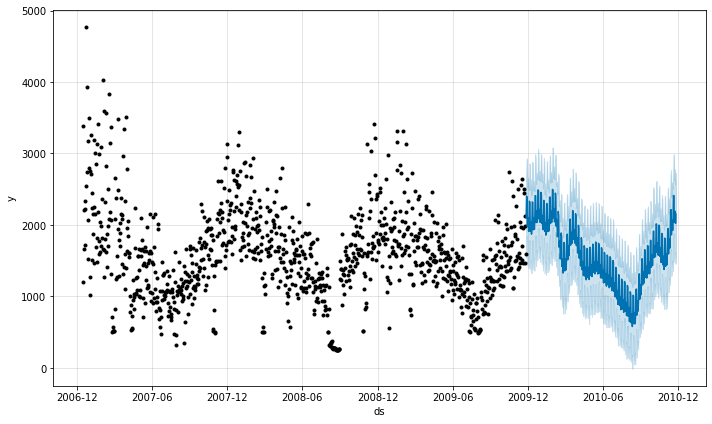

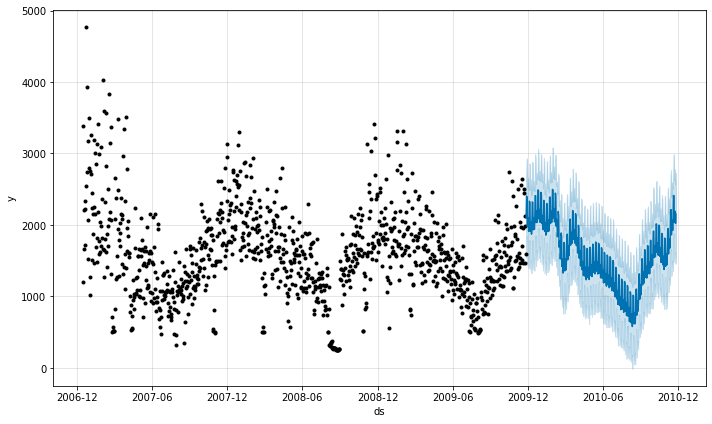

In [13]:
model.plot(forecast)

In [14]:
y_true = np.array(df_test['y'])
y_forecast = np.array(forecast['yhat'])
mape = np.mean(np.abs((y_true - y_forecast) / y_true)) * 100
round(mape, 2)

20.88

In [26]:
metric_df = forecast.set_index('ds')[['yhat']].join(df_test.set_index('ds').y).reset_index()

In [27]:
import ml_metrics as metrics
rmse_v1 = metrics.rmse(metric_df.y, metric_df.yhat)
round (rmse_v1, 2)

374.97

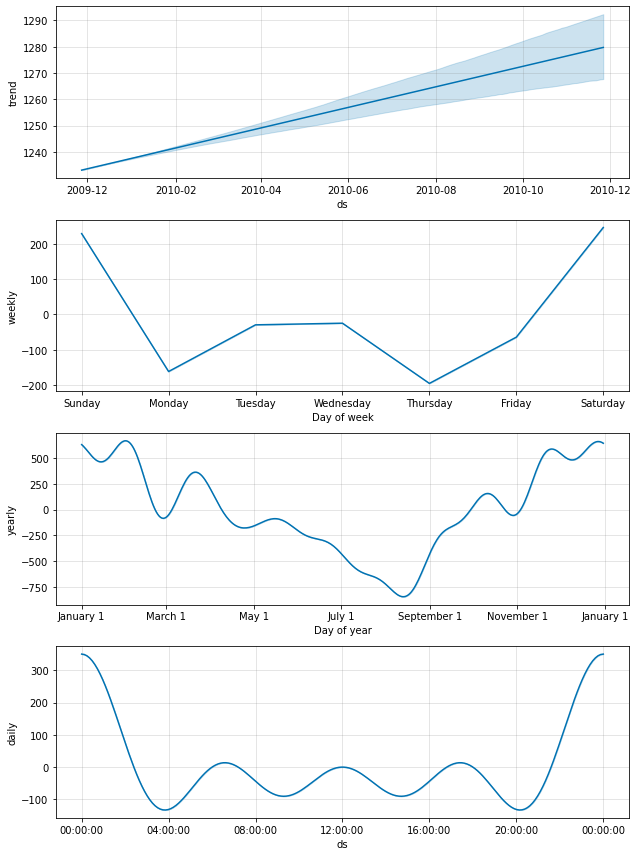

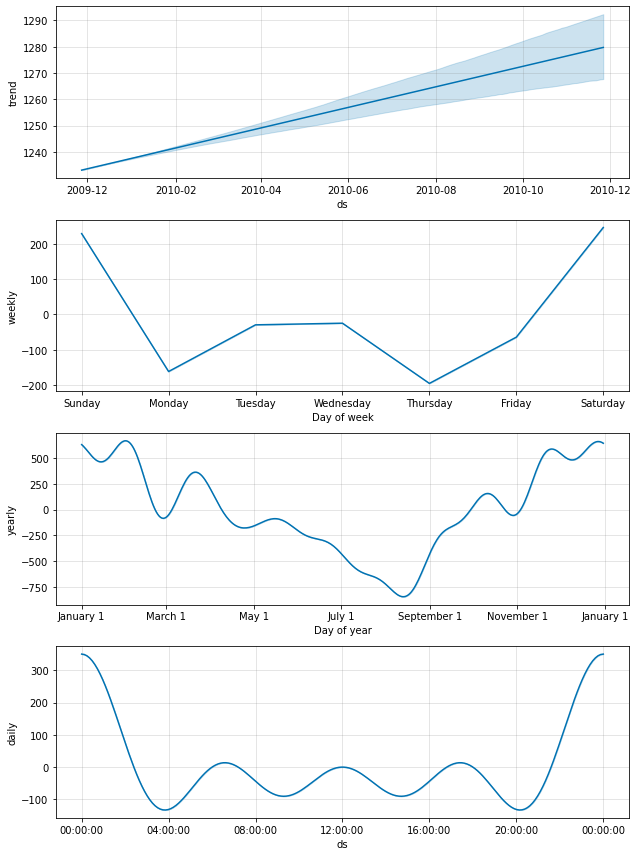

In [17]:
model.plot_components(forecast)

In [18]:
data['add1'] = dff['Global_reactive_power']
data['add2'] = dff['Voltage']
data['add3'] = dff['Global_intensity']
data['add4'] = dff['Sub_metering_1']
data['add5'] = dff['Sub_metering_2']
data['add6'] = dff['Sub_metering_3']

In [19]:
n_tests = 365
df_train = data[:-n_tests]
df_test = data[-n_tests:]

In [20]:
new_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
new_model.add_regressor('add1')
new_model.add_regressor('add2')
new_model.add_regressor('add3')
new_model.add_regressor('add4')
new_model.add_regressor('add5')
new_model.add_regressor('add6')
new_model.fit(df_train);

C:\Users\miky\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
forecast2 = new_model.predict(df_test)

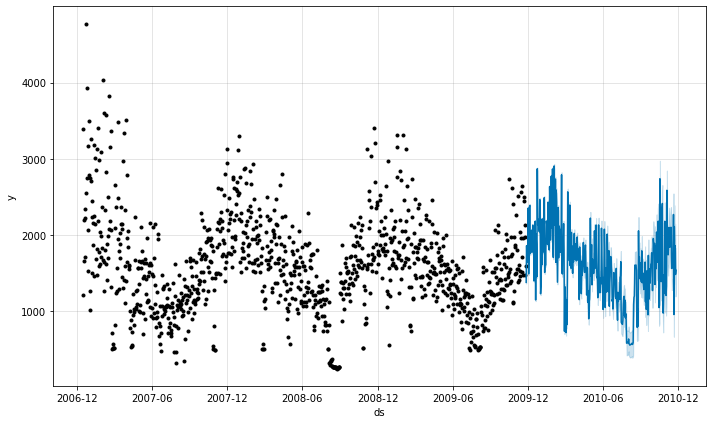

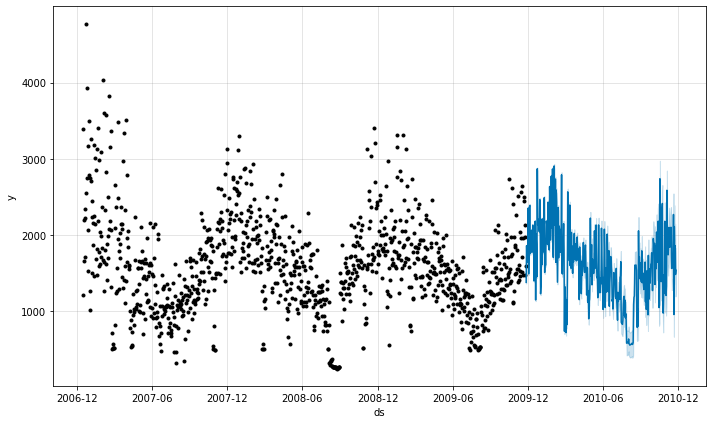

In [22]:
new_model.plot(forecast2)

In [23]:
metric_df = forecast2.set_index('ds')[['yhat']].join(df_test.set_index('ds').y).reset_index()

x1 = metric_df.y
y1 = metric_df.yhat

def mape (x1, y1):
    x1, y1 = np.array(x1), np.array(y1)
    return np.mean(np.abs((x1 - y1) / y1)) *100

mape(x1, y1)

2.35882445440879

In [24]:
rmse_v2 = metrics.rmse(metric_df.y, metric_df.yhat)
rmse_v2

36.66209134600112

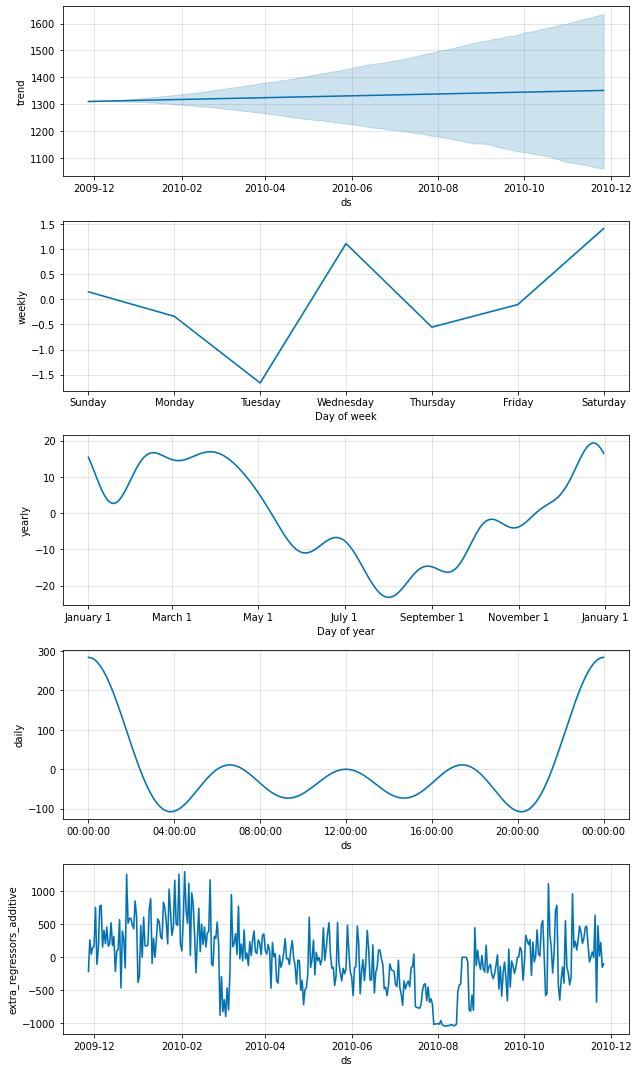

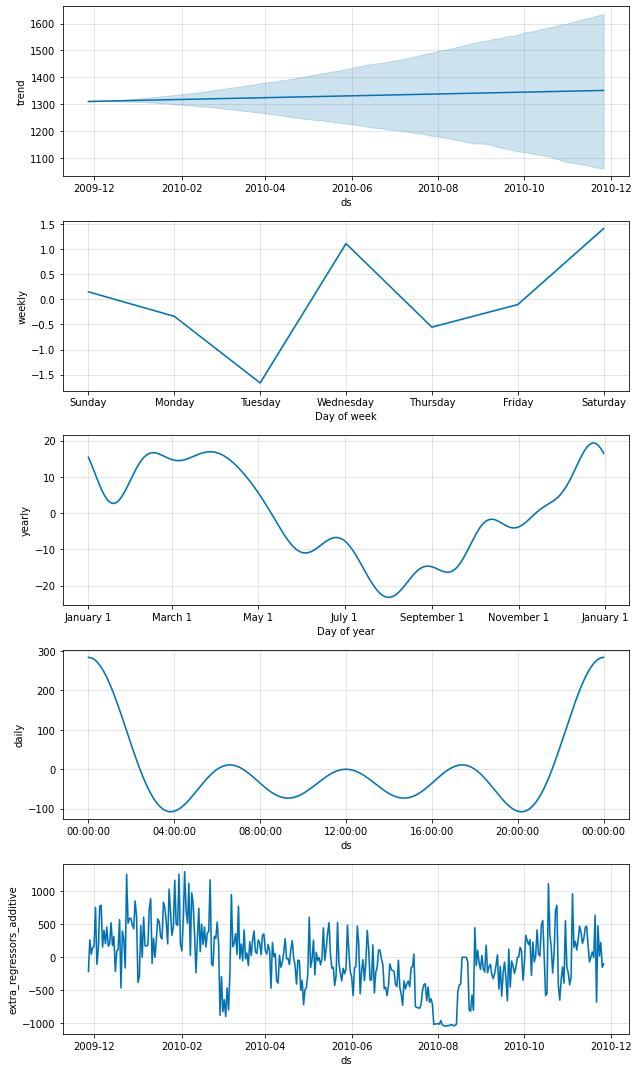

In [25]:
new_model.plot_components(forecast2)